# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 07.12.2021


Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# from sklearn.datasets import load_boston

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

In [3]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [4]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

32.377058630595194

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [5]:
def compute_bias_variance(regressor, X, y, num_runs=10):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    best_model = y
    n = len(X)
    mean_predictions = np.zeros(n)
    mean_squared_predictions = np.zeros(n)
    error = np.zeros(n)
    counts = np.zeros(n)
    
    for i in range(num_runs):
        bootstrap = np.random.randint(n, size=n)
        out_of_bag = np.arange(n)[np.isin(np.arange(n), np.unique(bootstrap), invert=True)]
        
        estimator = regressor.fit(X[bootstrap], y[bootstrap])
        predictions = estimator.predict(X[out_of_bag])
        
        mean_predictions[out_of_bag] += predictions
        mean_squared_predictions[out_of_bag] += predictions ** 2
        error[out_of_bag] += (predictions - y[out_of_bag]) ** 2
        counts[out_of_bag] += 1
    
    useful_objects = np.nonzero(counts)
    counts = counts[useful_objects]
    mean_predictions = mean_predictions[useful_objects]
    mean_squared_predictions = mean_squared_predictions[useful_objects]
    best_model = best_model[useful_objects]
    error = error[useful_objects]
    
    mean_predictions /= counts
    mean_squared_predictions /= counts
    
    bias = ((mean_predictions - best_model) ** 2).mean()
    variance = (mean_squared_predictions - (mean_predictions ** 2)).mean()
    error = error.sum() / counts.sum()
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

bvd = {'LinearRegression': compute_bias_variance(LinearRegression(), X, y),
       'DecisionTreeRegressor': compute_bias_variance(DecisionTreeRegressor(), X, y),
       'RandomForestRegressor': compute_bias_variance(RandomForestRegressor(), X, y)}

In [7]:
print("Результаты разложения ошибки на смещение и разброс")
bvd

Результаты разложения ошибки на смещение и разброс


{'LinearRegression': (23.790844485857956,
  0.5388301082748072,
  24.570349258057217),
 'DecisionTreeRegressor': (13.817514573181723,
  8.376590988761368,
  22.273267379679144),
 'RandomForestRegressor': (11.616465786280894,
  1.0492596892516255,
  14.273174310048356)}

In [8]:
print("Разница между 'реальной' ошибкой и рассчитанной")
diff = dict()
for est, res in bvd.items():
    bias, variance, error = res
    diff[est] = error - (bias + variance)
diff

Разница между 'реальной' ошибкой и рассчитанной


{'LinearRegression': 0.2406746639244517,
 'DecisionTreeRegressor': 0.07916181773605402,
 'RandomForestRegressor': 1.6074488345158358}

__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ можно утверждать, что ошибка метода обучения действительно с хорошей точностью приближается суммой смещения и разброса

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ бэггинг уменьшает разброс базовой модели не более чем в N раз, где N - кол-во базовых моделей. В нашем случае уменьшение не настолько значительное, так как разброс композиции это сумма дисперсии базового алгоритма, делённого на N, и ковариации между двумя базовыми моделями. Второе слагаемое как раз и мешает уменьшаться разбросу в N раз, так как в общем случае модели сложно сделать некоррелированными.

In [9]:
from sklearn.ensemble import BaggingRegressor

bagging = {'LinearRegression': BaggingRegressor(LinearRegression()).fit(X, y),
           'DecisionTreeRegressor': BaggingRegressor(DecisionTreeRegressor()).fit(X, y),
           'RandomForestRegressor': BaggingRegressor(RandomForestRegressor()).fit(X, y)}

In [10]:
bagging_bvd = {'LinearRegression': compute_bias_variance(bagging["LinearRegression"], X, y),
               'DecisionTreeRegressor': compute_bias_variance(bagging["DecisionTreeRegressor"], X, y),
               'RandomForestRegressor': compute_bias_variance(bagging["RandomForestRegressor"], X, y)}
bagging_bvd

{'LinearRegression': (23.651479277188596,
  0.5353812331242875,
  24.4982168966232),
 'DecisionTreeRegressor': (12.100492065419418,
  2.200644263551981,
  14.647069394261422),
 'RandomForestRegressor': (13.10287150201017,
  1.2080588536898216,
  13.92036005485854)}

In [11]:
variance_ratio = {'LinearRegression': bvd["LinearRegression"][1] / bagging_bvd["LinearRegression"][1],
                  'DecisionTreeRegressor': bvd["DecisionTreeRegressor"][1] / bagging_bvd["DecisionTreeRegressor"][1],
                  'RandomForestRegressor': bvd["RandomForestRegressor"][1] / bagging_bvd["RandomForestRegressor"][1]}
variance_ratio

{'LinearRegression': 1.0064419052016322,
 'DecisionTreeRegressor': 3.8064266576375285,
 'RandomForestRegressor': 0.8685501422772827}

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [12]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    n = len(X)
    test = np.random.choice(np.arange(n), num_test_objects, False)
    train = np.arange(n)[np.isin(np.arange(n), test, invert=True)]
    X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
    bagging = BaggingRegressor(regressor, num_runs).fit(X_train, y_train)
    x = np.arange(num_test_objects)
    for i in range(num_runs):
        i_predictions = bagging.estimators_[i].predict(X_test)
        plt.scatter(x, i_predictions, c='r')
    plt.scatter(0, y.min() - 2, c='r', label="predictions")
    plt.scatter(x, y_test, c='b', label="true")
    plt.title(title)
    plt.xlabel("номер объекта")
    plt.ylabel("значение целевой переменной")
    plt.legend()
    plt.xticks(np.arange(num_test_objects))
    plt.ylim((y.min() - 1, y.max() + 1))

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

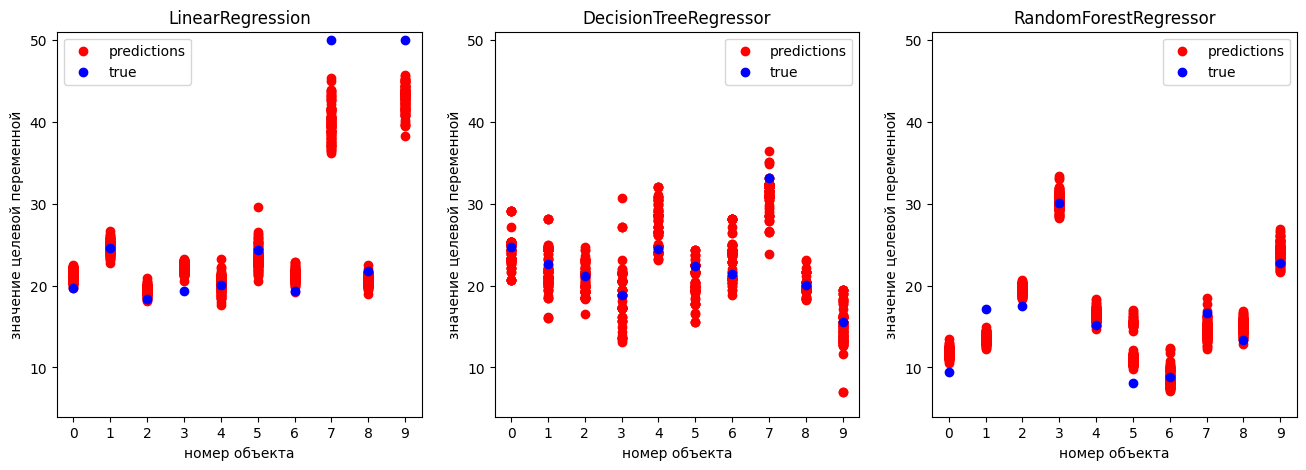

In [13]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
plot_predictions(LinearRegression(), X, y, title="LinearRegression")
plt.subplot(132)
plot_predictions(DecisionTreeRegressor(), X, y, title="DecisionTreeRegressor")
plt.subplot(133)
plot_predictions(RandomForestRegressor(), X, y, title="RandomForestRegressor")

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

__Линейная регрессия:__ из графика понятно, что метод смещён, но имеет маленький разброс
__Решающее дерево:__ из графика понятно, что метод имеет большой разброс но низкое смещение
__Случайный лес:__ из графика понятно, что метод имеет небольшие смещение и разброс 

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

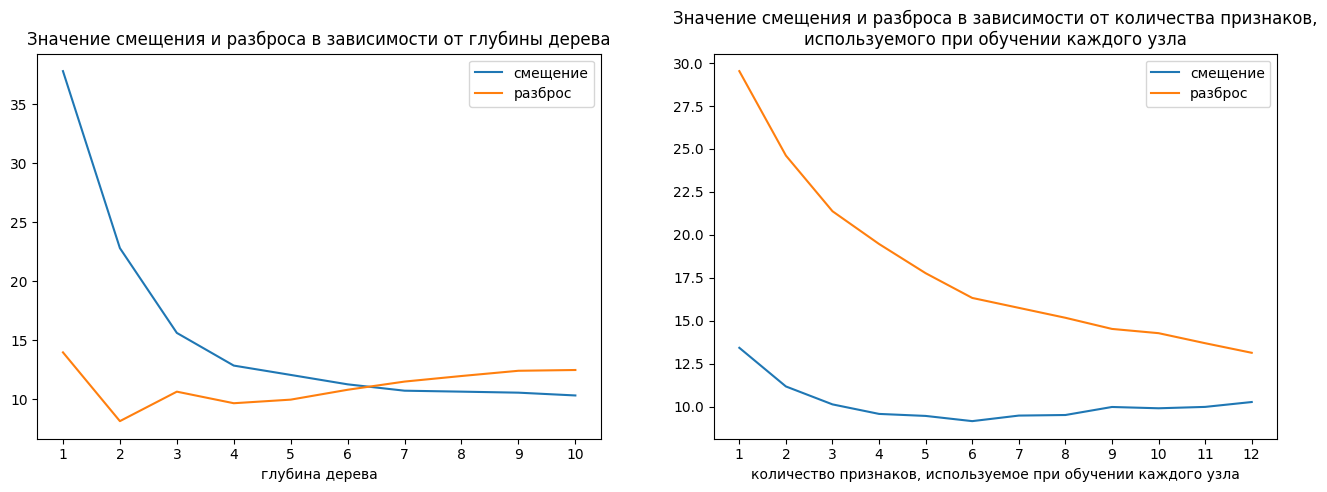

In [24]:
depth = np.arange(1, 11)
plt.figure(figsize=(16, 5))
plt.subplot(121)
bias = []
variance = []
for i in depth:
    b, v, e = compute_bias_variance(DecisionTreeRegressor(max_depth=i), X, y, num_runs=1000)
    bias.append(b)
    variance.append(v)
plt.plot(depth, bias, label='смещение')
plt.plot(depth, variance, label='разброс')
plt.legend()
plt.xlabel("глубина дерева")
plt.xticks(depth)
plt.title("Значение смещения и разброса в зависимости от глубины дерева")

plt.subplot(122)
n_features = X.shape[1]
features = np.arange(1, n_features)
bias = []
variance = []
for i in features:
    b, v, e = compute_bias_variance(DecisionTreeRegressor(max_features=i), X, y, num_runs=1000)
    bias.append(b)
    variance.append(v)
plt.plot(features, bias, label='смещение')
plt.plot(features, variance, label='разброс')
plt.legend()
plt.xlabel("количество признаков, используемое при обучении каждого узла")
plt.xticks(features)
plt.title("Значение смещения и разброса в зависимости от количества признаков,\nиспользуемого при обучении каждого узла");

__Смещение__ сильно зависит от глубины дерева, так как с её увеличением модель способна замечать более сложные закономерности в данных.
__Разброс__ слабо зависит от глубины, но растет с её увеличением. Это происходит из-за того, что глубокие деревья более склонны к переобучению и небольшие различия в обучающих выборках могут привести к разным по переобученности моделям.

__Смещение__ уменьшается с увеличением кол-ва признаков, которое используется при обучении каждого узла. Это происходит из-за того, что мы позволяем модели более тщательно обучать каждый узел.
__Разброс__ сильно зависит от кол-ва признаков, которое используется при обучении каждого узла. Это происходит из-за того, что модели при обучении не ограничены глубиной и при маленьком значении max_features получаются разные по "направлению" переобучению модели.

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

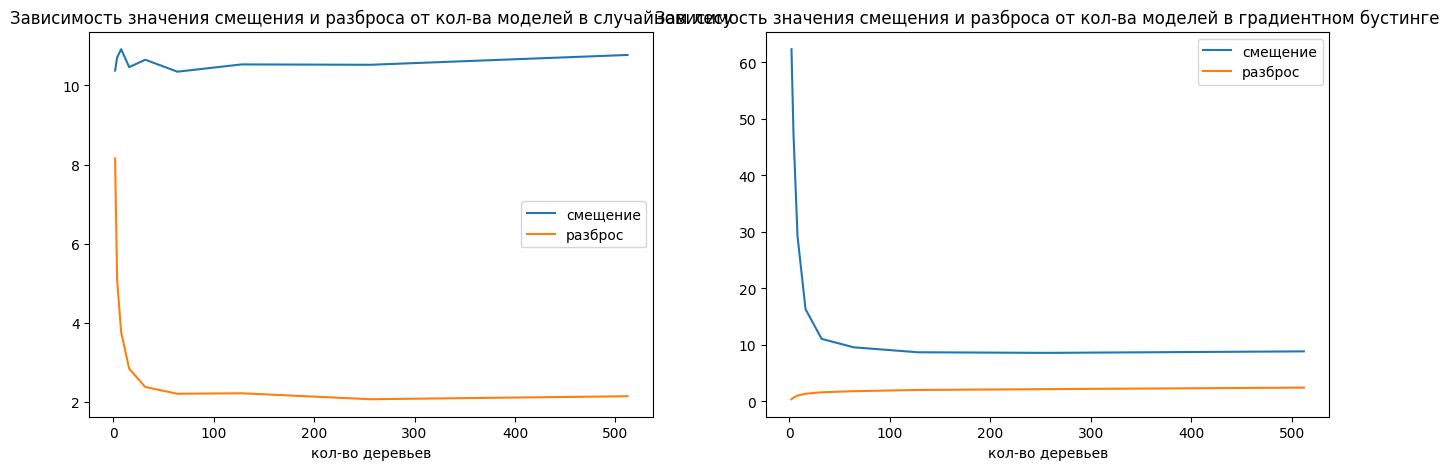

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

estimators = 2 ** np.arange(1, 10)
plt.figure(figsize=(16, 5))
plt.subplot(121)
bias = []
variance = []
for i in estimators:
    b, v, e = compute_bias_variance(RandomForestRegressor(n_estimators=i), X, y, num_runs=100)
    bias.append(b)
    variance.append(v)
plt.plot(estimators, bias, label='смещение')
plt.plot(estimators, variance, label='разброс')
plt.legend()
plt.xlabel("кол-во деревьев")
plt.title("Зависимость значения смещения и разброса от кол-ва моделей\nслучайный лес")

plt.subplot(122)
bias = []
variance = []
for i in estimators:
    b, v, e = compute_bias_variance(GradientBoostingRegressor(n_estimators=i), X, y, num_runs=100)
    bias.append(b)
    variance.append(v)
plt.plot(estimators, bias, label='смещение')
plt.plot(estimators, variance, label='разброс')
plt.legend()
plt.xlabel("кол-во деревьев")
plt.title("Зависимость значения смещения и разброса от кол-ва моделей\nградиентный бустинг");

__Смещение__ случайного леса можно считать неизменным. Так получается из-за того что базовые модели сами по себе слабо смещены
__Разброс__ случайного леса сначала очень быстро уменьшается, а затем выходит на плато. Так получается из-за того, что базовые модели заметно скоррелированы, но разброс зависит также от кол-ва базовых моделей (которое увеличивается).

__Смещение__ градиентного бустинга похоже графиком на разброс случайного леса, а его __разброс__ похож графиком на смещение случайного леса. Так получается из-за того, что базовые модели имеют небольшую глубину и каждое следующее дополняет результаты предыдущих деревьев. Однако с увеличением кол-ва деревьев в бустинге его качество сначала убывает, а затем возрастает и выходит на плато. Это происходит из-за того, что модели начинают подстраиваться под шум в данных

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.